In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import neurokit2 as nk

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error


from sklearn.linear_model import LinearRegression

from pmdarima import auto_arima

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import math

# Loading Data

In [112]:
SAMPLE_RATE = 100

In [113]:
df_all = pd.read_csv('ABPICP.csv', delimiter=';', decimal=',', names=['abp', 'icp'] )


In [114]:
df_all

,abp,icp
0,93.14,38.89
1,92.21,39.31
2,91.06,40.25
3,90.59,41.41
4,93.37,42.73
...,...,...
1048571,145.40,44.63
1048572,145.22,44.94
1048573,145.17,44.84
1048574,145.83,44.84


In [115]:
icp_signal = df_all.iloc[:100000]['icp'].values

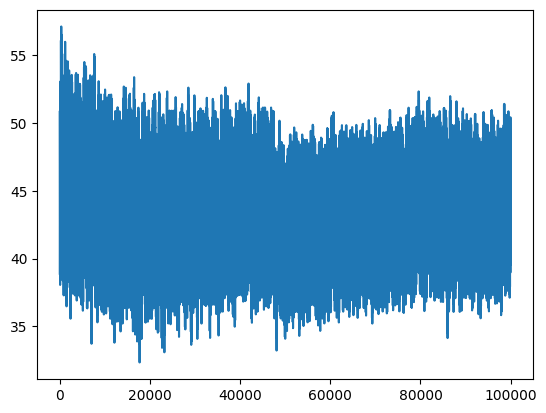

In [116]:
plt.plot(icp_signal)

In [117]:
peaks = nk.ppg_findpeaks(icp_signal, sampling_rate=SAMPLE_RATE)['PPG_Peaks']
peaks

array([  102,   184,   257, ..., 99797, 99872, 99948])

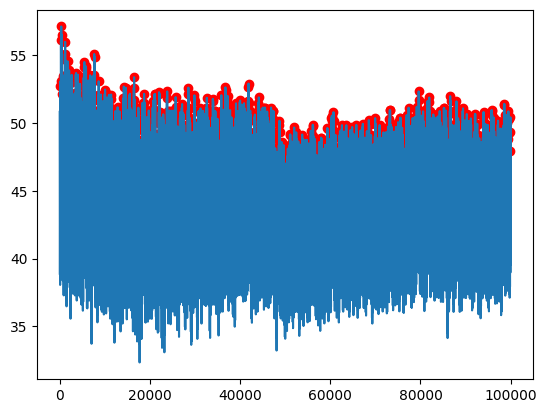

In [118]:
plt.plot(icp_signal)
plt.scatter(peaks, icp_signal[peaks], color='red')
plt.show()

In [119]:
peaks_distances = np.diff(peaks)
peaks_distances

array([82, 73, 75, ..., 77, 75, 76])

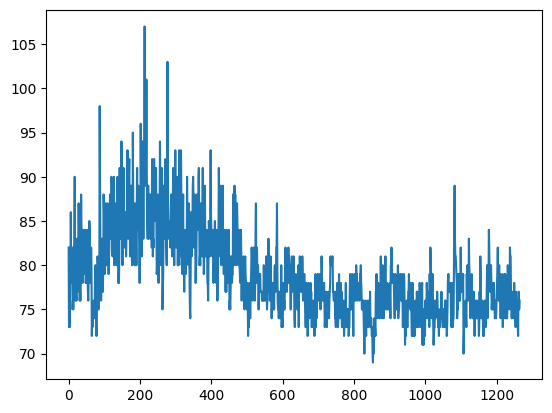

In [120]:
plt.plot(peaks_distances)

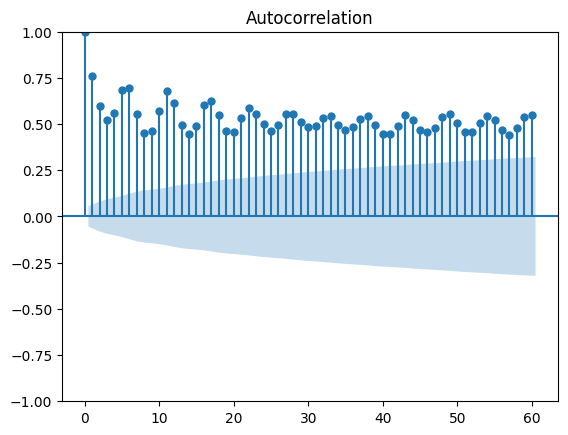

In [121]:
fig = plot_acf(peaks_distances, lags=60)

In [122]:
acorr_ljungbox(peaks_distances, lags=60)

,lb_stat,lb_pvalue
1,731.568000,4.085529e-161
2,1181.886255,2.273320e-257
3,1529.290361,0.000000e+00
4,1927.621277,0.000000e+00
5,2520.850924,0.000000e+00
6,3134.076842,0.000000e+00
7,3522.305424,0.000000e+00
8,3782.054182,0.000000e+00
9,4053.447759,0.000000e+00
10,4468.459996,0.000000e+00


peaks distance change have autocorelations

In [123]:
adfuller(peaks_distances)

(-2.010154421396667,
 0.28213856468861653,
 23,
 1241,
 {'1%': -3.435630320520318,
  '5%': -2.863871779019612,
  '10%': -2.56801146937726},
 5843.259934364003)

peaks distance change is stationary

# Predicting distance to next peak

## XGBoost

In [124]:
window_size = 20
X = [peaks_distances[i:i+window_size] for i in range(len(peaks_distances)-window_size)]
y = peaks_distances[window_size:]

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

xgbr_grid = {
  'n_estimators': [50, 100, 200, 300, 400], 
  'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
  'learning_rate': [0.01, 0.02, 0.03],
  'random_state': [42], 
  }

xgbr = XGBRegressor()
xgbr_random = RandomizedSearchCV(estimator = xgbr, param_distributions = xgbr_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
xgbr_random.fit(X_train, y_train)
peak_distance_model_xgb = xgbr_random.best_estimator_

predictions = peak_distance_model_xgb.predict(X_test)

c:\Python312\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 90 is smaller than n_iter=100. Running 90 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 90 candidates, totalling 270 fits


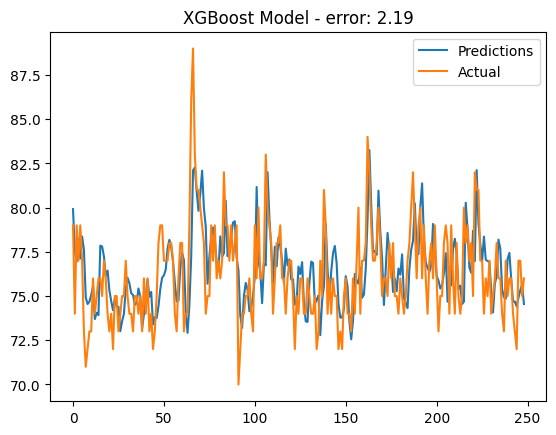

In [125]:
plt.plot(predictions)
plt.plot(y_test)
plt.title(f'XGBoost Model - error: {mean_absolute_percentage_error(y_test, predictions)*100:.2f}')
plt.legend(['Predictions', 'Actual'])
plt.show()

## Linear Regression

In [126]:
peak_distance_model_linear = LinearRegression()
peak_distance_model_linear.fit(X_train, y_train)

predictions_2 = peak_distance_model_linear.predict(X_test)

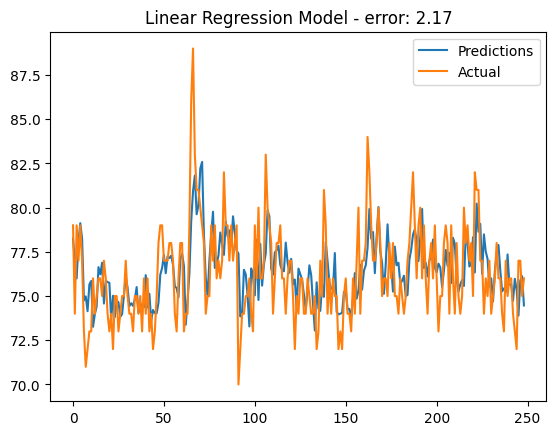

In [127]:
plt.plot(predictions_2)
plt.plot(y_test)
plt.title(f'Linear Regression Model - error: {mean_absolute_percentage_error(y_test, predictions_2)*100:.2f}')
plt.legend(['Predictions', 'Actual'])
plt.show()

Linear regression has advantage on smaller datasets and is faster to train

# Predicting shape based on previous shape

In [128]:
df = df_all[['icp']].iloc[:5000]

In [129]:
scaler = MinMaxScaler()
train = df.iloc[:-90]
test = df.iloc[-90:]

In [130]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [131]:
n_input = 90
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=n_features)

In [132]:
model = Sequential()
model.add(LSTM(16, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [133]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 16)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,169 (4.57 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

In [134]:
model.fit(generator, epochs=8)

Epoch 1/8


  13/4820 ━━━━━━━━━━━━━━━━━━━━ 1:04 13ms/step - loss: 0.4042

c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4820/4820 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 0.0178
Epoch 2/8
4820/4820 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 5.0768e-04
Epoch 3/8
4820/4820 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - loss: 2.2909e-04
Epoch 4/8
4820/4820 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 1.7972e-04
Epoch 5/8
4820/4820 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 1.5867e-04
Epoch 6/8
4820/4820 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 1.5953e-04
Epoch 7/8
4820/4820 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 1.5225e-04
Epoch 8/8
4820/4820 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 1.4107e-04


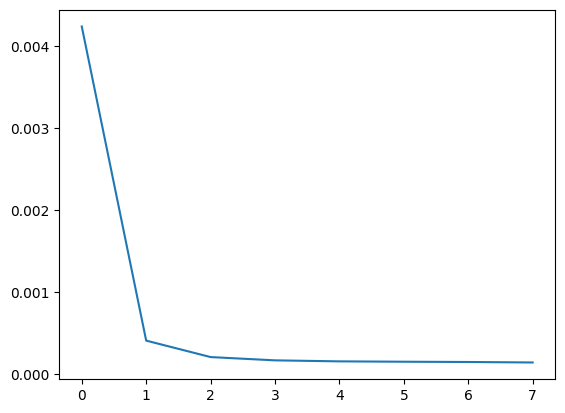

In [135]:
loss_per_epoch = model.history.history['loss']
plt.plot(loss_per_epoch)

In [136]:
prediction = model.predict(scaled_test)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000247260319E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [137]:
prediction = scaler.inverse_transform(prediction)

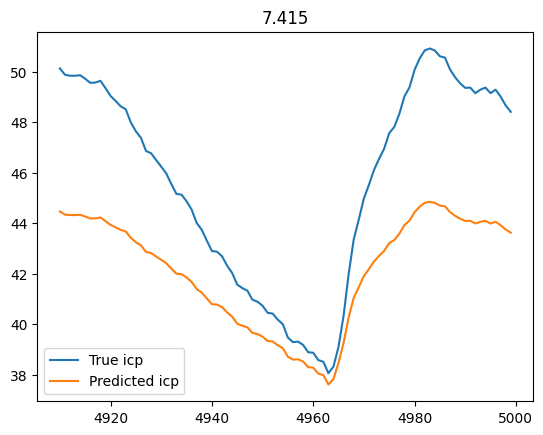

In [138]:
plt.plot(test.index, test['icp'], label='True icp')
plt.plot(test.index, prediction, label='Predicted icp')
plt.title(f'{mean_absolute_percentage_error(test, prediction)*100:.3f}')
plt.legend()

# Predicting shape with standarisation of peak to peak points number

In [139]:
icp_values = df_all['icp'].values
peaks = nk.ppg_findpeaks(icp_signal, sampling_rate=SAMPLE_RATE)['PPG_Peaks']

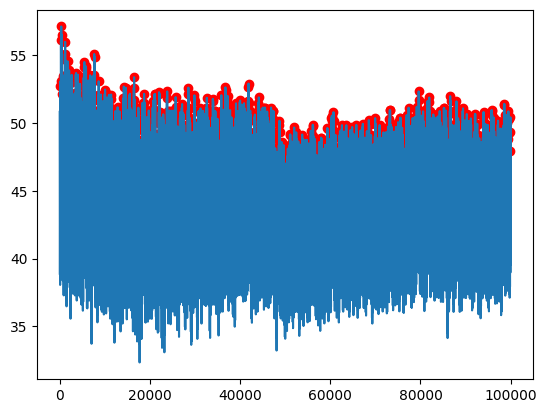

In [140]:
plt.plot(icp_signal)
plt.scatter(peaks, icp_signal[peaks], color='red')
plt.show()

In [141]:
peaks

array([  102,   184,   257, ..., 99797, 99872, 99948])

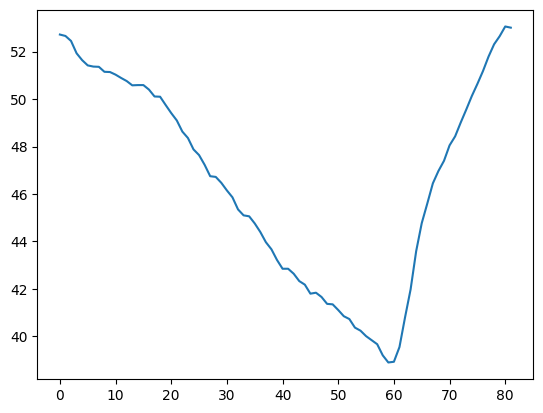

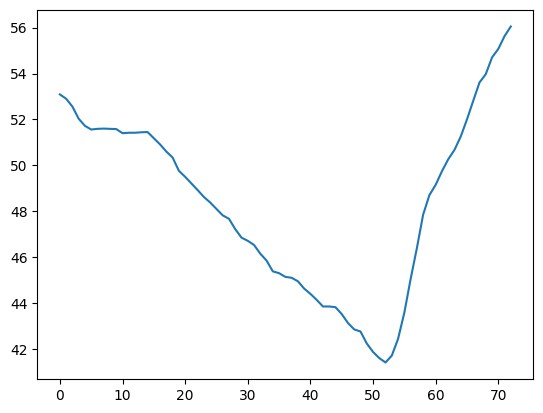

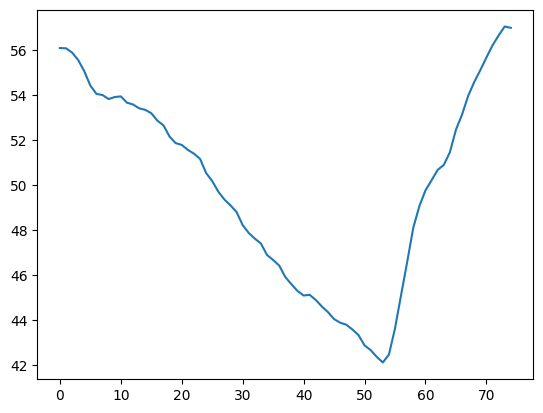

In [142]:
# divid my dataset to peak to peak segments
segments = []
for i in range(len(peaks)-1):
    segment = icp_signal[peaks[i]:peaks[i+1]]
    segments.append(segment)
    if i<3:
        plt.plot(segment)
        plt.show()

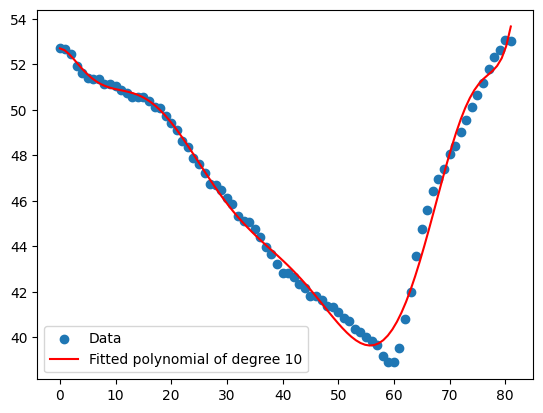

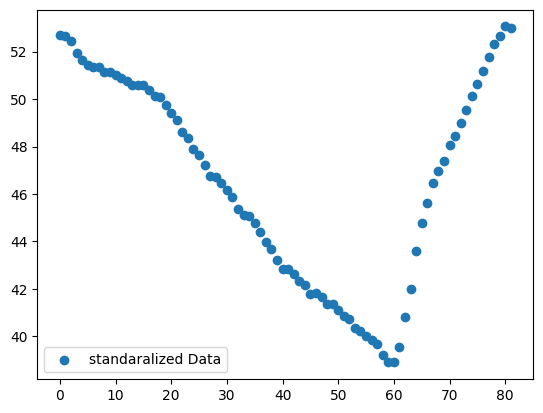

In [143]:
test_seg = segments[0]
seg_x = np.arange(len(test_seg))

coefficients = np.polyfit(seg_x, test_seg, 10)
polynomial = np.poly1d(coefficients)

x_values = np.linspace(min(seg_x), max(seg_x), 100)
y_values = polynomial(x_values)

plt.scatter(seg_x, test_seg, label='Data')
plt.plot(x_values, y_values, color='red', label='Fitted polynomial of degree {}'.format(10))
plt.legend()
plt.show()

new_seg_x = np.linspace(0, len(test_seg), 100)
new_seg_y = polynomial(new_seg_x)
plt.scatter(seg_x, test_seg, label='standaralized Data')
plt.legend()
plt.show()

In [144]:
def standardize_segment(segment):
    coefficients = np.polyfit(np.arange(len(segment)), segment, 10)
    polynomial = np.poly1d(coefficients)
    new_segment = polynomial(np.linspace(0, len(segment), 100))
    return new_segment

In [145]:
standaralized_segments = [standardize_segment(segment) for segment in segments]

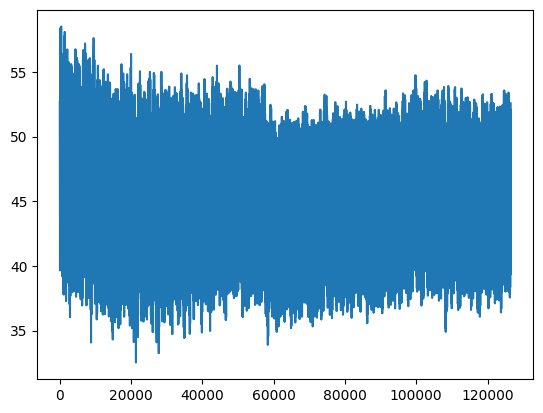

In [146]:
# conect the standaralized segments
merged_segments = np.concatenate(standaralized_segments)
plt.plot(merged_segments)

In [147]:
standaralized_df = pd.DataFrame(merged_segments, columns=['icp'])
standaralized_df

,icp
0,52.705107
1,52.625995
2,52.454037
3,52.234128
4,51.998819
...,...
126495,49.473167
126496,49.799000
126497,50.347825
126498,51.228914


In [ ]:
train = standaralized_df.iloc[:-100]
test = standaralized_df.iloc[-100:]

In [173]:
df_comp = test['icp'].to_frame()
df_comp.reset_index(drop=True, inplace=True)
df_comp

,icp
0,49.323467
1,49.453189
2,49.420243
3,49.287317
4,49.101339
...,...
95,49.473167
96,49.799000
97,50.347825
98,51.228914


## LSTM

In [157]:
scaler = MinMaxScaler()

In [158]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [159]:
n_input = 100
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=n_features)

In [161]:
model = Sequential()
model.add(LSTM(16, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [162]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 16)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,169 (4.57 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

In [164]:
model.fit(generator, epochs=3)

Epoch 1/3


126300/126300 ━━━━━━━━━━━━━━━━━━━━ 919s 7ms/step - loss: 1.1098e-04
Epoch 2/3
126300/126300 ━━━━━━━━━━━━━━━━━━━━ 937s 7ms/step - loss: 4.2496e-05
Epoch 3/3
126300/126300 ━━━━━━━━━━━━━━━━━━━━ 928s 7ms/step - loss: 2.8465e-05


In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(loss_per_epoch)

In [165]:
prediction = model.predict(scaled_test)
rescaled_prediction = scaler.inverse_transform(prediction)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [175]:
df_comp['LSTM'] = rescaled_prediction

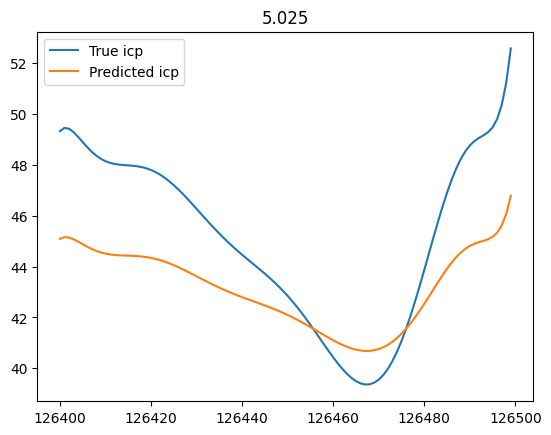

In [166]:
plt.plot(test.index, test['icp'], label='True icp')
plt.plot(test.index, rescaled_prediction, label='Predicted icp')
plt.title(f'{mean_absolute_percentage_error(test, rescaled_prediction)*100:.3f}')
plt.legend()

## XGBoost

In [187]:
data = standaralized_df.copy()

In [188]:
for i in range(100,0,-1):
  data['t='+str(i)] = data['icp'].shift(i)
data.dropna(inplace=True)

C:\Users\Ignacy\AppData\Local\Temp\ipykernel_22460\1098537540.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['t='+str(i)] = data['icp'].shift(i)


In [189]:
data

,icp,t=100,t=99,t=98,t=97,t=96,t=95,t=94,t=93,t=92,...,t=10,t=9,t=8,t=7,t=6,t=5,t=4,t=3,t=2,t=1
100,53.043662,52.705107,52.625995,52.454037,52.234128,51.998819,51.770534,51.563521,51.385552,51.239384,...,50.906993,51.179818,51.391792,51.568102,51.747337,51.984282,52.353075,52.950731,53.901073,55.359098
101,52.934929,52.625995,52.454037,52.234128,51.998819,51.770534,51.563521,51.385552,51.239384,51.124023,...,51.179818,51.391792,51.568102,51.747337,51.984282,52.353075,52.950731,53.901073,55.359098,53.043662
102,52.722859,52.454037,52.234128,51.998819,51.770534,51.563521,51.385552,51.239384,51.124023,51.035788,...,51.391792,51.568102,51.747337,51.984282,52.353075,52.950731,53.901073,55.359098,53.043662,52.934929
103,52.465735,52.234128,51.998819,51.770534,51.563521,51.385552,51.239384,51.124023,51.035788,50.969208,...,51.568102,51.747337,51.984282,52.353075,52.950731,53.901073,55.359098,53.043662,52.934929,52.722859
104,52.204455,51.998819,51.770534,51.563521,51.385552,51.239384,51.124023,51.035788,50.969208,50.917767,...,51.747337,51.984282,52.353075,52.950731,53.901073,55.359098,53.043662,52.934929,52.722859,52.465735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126495,49.473167,47.632141,47.977818,48.692234,49.980365,52.105256,49.323467,49.453189,49.420243,49.287317,...,46.901637,47.405207,47.847990,48.222802,48.526204,48.759728,48.931273,49.056693,49.161585,49.283298
126496,49.799000,47.977818,48.692234,49.980365,52.105256,49.323467,49.453189,49.420243,49.287317,49.101339,...,47.405207,47.847990,48.222802,48.526204,48.759728,48.931273,49.056693,49.161585,49.283298,49.473167
126497,50.347825,48.692234,49.980365,52.105256,49.323467,49.453189,49.420243,49.287317,49.101339,48.896257,...,47.847990,48.222802,48.526204,48.759728,48.931273,49.056693,49.161585,49.283298,49.473167,49.799000
126498,51.228914,49.980365,52.105256,49.323467,49.453189,49.420243,49.287317,49.101339,48.896257,48.695467,...,48.222802,48.526204,48.759728,48.931273,49.056693,49.161585,49.283298,49.473167,49.799000,50.347825


In [191]:
X = data.iloc[:,1:].values
y = data.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [192]:
xgbr_grid = {
  'n_estimators': [50, 100, 200, 300, 400], 
  'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
  'learning_rate': [0.01, 0.02, 0.03],
  'random_state': [42], 
  }
best_score = -float('inf')

best_model = None

for g in ParameterGrid(xgbr_grid):
  model = XGBRegressor(**g)
  model.fit(X_train, y_train)
  score = model.score(X_test, y_test)

  if score > best_score:
    best_score = score
    best_model = model

train_predict = best_model.predict(X_train)
test_predict = best_model.predict(X_test)

print('Error for train data:')
print(mean_absolute_percentage_error(y_train, train_predict) * 100)
print('Error for test data:')
print(mean_absolute_percentage_error(y_test, test_predict) * 100)

Error for train data:
0.0889114117013438
Error for test data:
0.09872605018699206


In [193]:
def get_first_eval_batch(data, n):
  return data[-n:].reshape(-1,n)

In [194]:
n_lag = 100
test_pred = []
current_batch = get_first_eval_batch(train['icp'].values, n_lag)
for i in range(len(test)):
  current_pred = best_model.predict(current_batch)[0]
  test_pred.append(current_pred)
  current_batch = np.append(current_batch[:,1:], current_pred).reshape(-1, n_lag)

In [195]:
df_comp['XGBoost'] = test_pred

## SARIMAX

In [199]:
auto_arima = auto_arima(train, seasonal=True, m=100, trace=True)

Performing stepwise search to minimize aic


KeyboardInterrupt: 